In [1]:
import typing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import QuantLib as ql
import yfinance as yf
import pandas_market_calendars as mcal
import constants as cs
import datetime


In [2]:
class SIXTradingCalendar:
    def __init__(self) -> None:
        self.six_trading_calendar = self.create_six_trading_dates('2020-01-01', '2025-12-31')
        
    def calculate_business_days(self, start_date, end_date):
        """
        Calculate the number of SIX Swiss Exchange business days between two dates, inclusive.
        The start and end date can be non-business days.

        Parameters:
            start_date (pd.Timestamp): The start date for the calculation.
            end_date (pd.Timestamp): The end date for the calculation.

        Returns:
            int: The number of business days between start_date and end_date, inclusive.
        """
        six_calendar = mcal.get_calendar('SIX')
        return len(six_calendar.valid_days(start_date, end_date).tz_localize(None))

    def create_six_trading_dates(self, start_date, end_date):
        """
        Create a DataFrame of trading dates for the SIX Swiss Exchange within a given date range.

        Parameters:
            start_date (str): The start date (inclusive) to generate trading dates from in 'YYYY-MM-DD' format.
            end_date (str): The end date (inclusive) to generate trading dates to in 'YYYY-MM-DD' format.

        Returns:
            pd.DataFrame: A DataFrame where each row represents a trading day within the date range.
                          The DataFrame's index is named 'Dates' and contains the trading dates.
        """
        six_calendar = mcal.get_calendar('SIX')
        print(f"Holidays in the calendar up to 2200: {six_calendar.holidays().holidays[-10:]}")
        six_trading_days = six_calendar.valid_days(start_date, end_date).tz_localize(None)

        six_trading_days_df = pd.DataFrame(index = six_trading_days)
        
        # Name the index "Dates"
        six_trading_days_df.index.name = 'Dates'
        return six_trading_days_df

    def add_trading_day(self, trading_date: pd.Timestamp, num_trading_day: int) -> pd.Timestamp:
        """
        Adds a specified number of trading days to a given date within the range of 2020 to 2025.

        Parameters:
        trading_date (pd.Timestamp): The trading date from which to add trading days.
        num_trading_day (int): The number of trading days to add, can be negative.

        Returns:
        pd.Timestamp: The resulting date after adding the trading days.

        Raises:
        ValueError: If the `trading_date` is not a valid trading date or out of the date range.
        IndexError: If the resulting trading date is out of the valid date range.
        """

        # Assuming create_six_trading_dates returns a pd.DatetimeIndex with trading dates
        try:
            position = self.six_trading_calendar.index.get_loc(trading_date)
            print(position)
        except:
            raise ValueError(f"{trading_date} is not a trading date or is out of the given date range.")

        new_position = position + num_trading_day

        try:
            return self.six_trading_calendar.index[new_position] # Returns the index of the position (cannot use iloc)
        except:
            raise IndexError("The resulting trading date is out of bounds.")

    # Input: a dataframe ith dates as index
    def remove_SIX_holidays(data: pd.DataFrame) -> pd.DataFrame:
        """
        Removes rows from the DataFrame that correspond to SIX Swiss Exchange holidays.

        This method assumes that the DataFrame's index is a DatetimeIndex with dates that
        potentially include holidays. It filters out any dates that are present in the
        predefined list of SIX holidays.

        Parameters:
            data (pd.DataFrame): A DataFrame with dates as its index, which represents
                                 trading days including holidays.

        Returns:
            pd.DataFrame: A DataFrame with the same structure as the input but with
                          holidays removed from the index.

        Note:
            The SIX holiday dates are obtained from a predefined list `cs.SIX_HOLIDAY_DATES`.
        """
        # Ensure that the dates you are trying to drop exist in the index
        dates_to_drop = [date for date in cs.SIX_HOLIDAY_DATES if date in data.index]
        print(f"The dates to drop are: {dates_to_drop}")

        # Drop the dates
        dropped_data = data.drop(dates_to_drop)
        # print(dropped_data)
        return dropped_data

if __name__ == "__main__":
    # Create an instance of the SIXTradingCalendar class
    trading_calendar = SIXTradingCalendar()

    # Perform various operations using the class instance
    # For example, calculate the number of business days between two dates
    start_date = pd.Timestamp('2023-01-01')
    end_date = pd.Timestamp('2023-01-10')
    business_days = trading_calendar.calculate_business_days(start_date, end_date)
    print(f"Number of business days: {business_days}")
    

Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Number of business days: 6


In [3]:
# In the main codes, we can create different models, and at the end access the sim_data to plot all the payoff_df aaginst the product prices
class PricingModel:
    def __init__(self, params: typing.Dict):
        self.data = params.get('data') # Stock price data for underlying asset (can include max data, in the training function can customise what dates to use)
        self.calendar = SIXTradingCalendar()
        self.ticker_list = params.get('ticker_list')
        self.time_steps_per_year = 252
        self.dt = 1/self.time_steps_per_year
        self.num_ticker = len(self.ticker_list) # Number of stocks
        self.sim_data = None # To store simulated paths of the underlying assets
        self.payoff_df = None # To store payoff calculations based on simulated data
        self.Z_list = None

    # Implementation of the multi-asset Geometric Brownian Motion model
    def multi_asset_gbm(self, sim_start_date: pd.Timestamp, hist_window: int, 
                        sim_window: int, h_adjustment: float) -> pd.DataFrame: 
        """
        Perform a simulation of multi-asset Geometric Brownian Motion (GBM) with
        a h_adjustment to the initial stock price for all assets.

        This function simulates asset paths over a specified window without 
        considering the actual dates. After the simulation, the business days 
        must be concatenated with the simulated data.

        Parameters:
        - sim_start_date (pd.Timestamp): The first day of simulation, which is 
        one business day after the product estimation date.
        - hist_window (int): The number of days to refer in yfinance, usually 252 
        which corresponds to the number of trading days in a year.
        - sim_window (int): The number of days to simulate.
        - h_adjustment (float): The adjustment to the stock price St.

        Returns:
        - pd.DataFrame: A DataFrame containing the simulated asset paths. Each 
        column represents an asset, and each row represents a simulated value 
        on a given day.

        Raises:
        - ValueError: If the provided `sim_start_date` is not a business day or 
        other specific conditions are not met (if applicable).

        Example:
        >>> sim_data = instance.multi_asset_gbm(pd.Timestamp('2023-01-01'), 252, 180)
        >>> print(sim_data)
        """
        interest_rate = 1.750/100 

        try:
            last_avai_price_date = self.calendar.add_trading_day(sim_start_date, -1)
            S_t = [self.data.loc[last_avai_price_date, ticker] + h_adjustment
                    for ticker in self.ticker_list] # Stock price of the 0th day of simulation            
            hist_data = self.data[self.data.index < sim_start_date].tail(hist_window)
            
        
        except Exception as e:
            raise Exception("Error at wrangling historical data.")

        try:
            log_returns_list = []
            for ticker in self.ticker_list:
                # display(data[ticker], data[ticker].shift(1))
                log_returns = np.log(hist_data[ticker] / hist_data[ticker].shift(1)) # np.log is natural log, (P_i/P_i-1)
                log_returns.dropna(inplace = True) # A series
                log_returns_list.append(log_returns)
                # print(type(log_returns))

            # print(log_returns_list)
            # print(np.shape(log_returns_list))

            # print(f"np.array {np.array(log_returns_list)}")
        
        except Exception as e:
            raise Exception("Error at generating log return.")
        
        try:
            cov_matrix = np.cov(np.array(log_returns_list))
            print(f"Covariance matrix is:\n {cov_matrix}\n")
            print(f"The shape is {np.shape(cov_matrix)}\n")

            print(f"Correlation between the two var is {cov_matrix[0][1] / (cov_matrix[0][0] * cov_matrix[1][1]) ** 0.5}") # Correct

            L = np.linalg.cholesky(cov_matrix)
            print(f"The matrix after Cholesky decomposition is:\n {L}\n")

            print(f"The multiplication of L and L transpose is:\n {np.dot(L, L.T)}\n") 

            sim_data = pd.DataFrame(np.zeros((sim_window, self.num_ticker)), columns = [self.ticker_list])

        except Exception as e:
            raise Exception("Error at covariance matrix.")

        # display(sim_data)
        
        if self.Z_list == None: self.Z_list = np.random.normal(0, 1, (self.num_ticker, sim_window))
        # print(sim_data.loc[0, "LONN.SW"])
        try:
            for t in range(sim_window):
                 # returns a scalar if size is not specified
                Z = self.Z_list[:, t]
                for i in range(self.num_ticker): # day need to go first, 
                    if t == 0: prev_price = S_t[i]
                    else: prev_price = sim_data.loc[t - 1, self.ticker_list[i]].item()
                    LZ = np.dot(L, Z.T) # For 1D vector the transpose doesn't matter, but for higher dimension yes
                    print("The 3 matrices are", L, Z, LZ)

                    print(type(prev_price), type(cov_matrix[i][i]), type(LZ[i]))
                    print(interest_rate, cov_matrix[i][i], LZ[i])
                    sim_data.loc[t, self.ticker_list[i]] = prev_price * np.exp(interest_rate * self.dt - 0.5 * cov_matrix[i][i] * self.dt + LZ[i]) # The cov matrix and L need to be computed on the fly
            sim_data.plot()
            return sim_data
        
        except Exception as e:
            raise Exception("Error at simulating.")
        pass

    def interest_rate_model(self, parameters):
        # Implementation of the interest rate model (e.g., Vasicek, CIR)
        pass
    
    def heston_model(self, parameters):
        # Implementation of the Heston model for option pricing
        pass

    def monte_carlo_simulation(self, parameters):
        # General Monte Carlo simulation method
        pass
    
    def apply_control_variate(self, control_parameters):
        # Method to apply control variate techniques to reduce simulation variance
        pass

    def calculate_payoff_all_features(self, parameters):
        # Method to calculate payoff with all features like barrier, autocallable, stock conversion
        pass

    def calculate_payoff_barrier(self, parameters):
        # Method to calculate payoff with barrier feature only (for eg.)
        pass

    def plot_simulated_data(self, some_paramenters):
        # Not sure whether this should be subplot to compare with other pricing models or a plot for this current model only
        pass



# Example usage:
# hist_stock_data = pd.DataFrame(...)  # This would be your historical stock data
# pricing_model = PricingModel(hist_stock_data)
# Call methods as needed:
# pricing_model.multidimensional_gbm(some_gbm_parameters)
# pricing_model.apply_control_variate(control_variate_parameters)

[*********************100%%**********************]  2 of 2 completed


,LONN.SW,SIKA.SW
Date,,
2023-08-08,491.200012,267.5


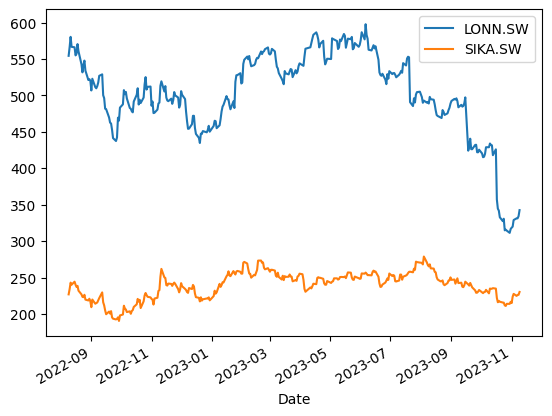

In [4]:
historical_start_date = '2022-08-09'
# Define the ticker list
ticker_list = ['LONN.SW', 'SIKA.SW']

# Fetch the data
data = yf.download(ticker_list, historical_start_date)['Adj Close'] # Auto adjust is false
data.plot()
display(data[data.index == pd.to_datetime('2023-08-08')])

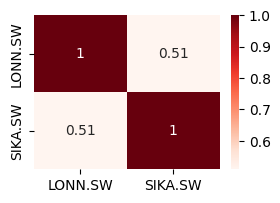

In [5]:
plt.figure(figsize=(3,2))
sns.heatmap(data.corr(), cmap="Reds", annot=True)
plt.show()

Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200

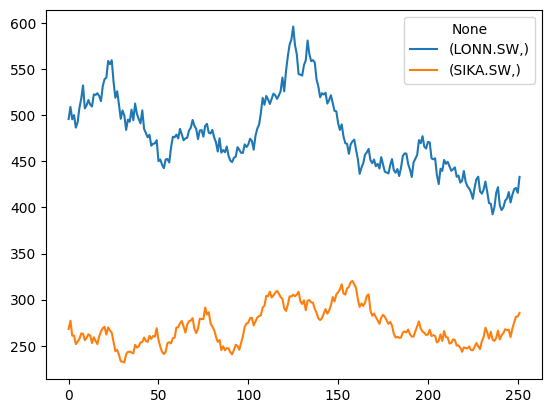

In [6]:
params = {
    'data': data,
    'ticker_list': ['LONN.SW', 'SIKA.SW']
}
trading_calendar = SIXTradingCalendar()
test_model = PricingModel(params = params)

bus_date_range = trading_calendar.create_six_trading_dates('2023-08-09', '2023-08-09')
# display(bus_date_range)
# print(bus_date_range.index.to_list())
for product_est_date in bus_date_range.index:
    # print(date, type(date))
    
    try:
        sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
        sim_data = test_model.multi_asset_gbm(
            sim_start_date= sim_start_date, 
            hist_window=trading_calendar.calculate_business_days(sim_start_date, 
                                                                 cs.FINAL_FIXING_DATE), 
            sim_window=252, h_adjustment=0)
        # display(sim_data)
    except Exception as e:
        # Log the error with the date that caused it
        raise Exception("MultiGBM has error.")
    
    sim_data.columns = ['LONN.SW', 'SIKA.SW']
    sim_data['LONN.SW'] 

    # TODO: Tag the sim_data with the dates
    # TODO: Add the concate the yfinance data from initial fixing date to the sim_data
    # TODO: Break the df into 2 df, each with date as one of the columns (not the index) for sc payoff function
    # Get the data?

    
    # TODO: Store the payoff df to the class and plot?

# TODO: Implement the second simulation with the control variate method? Another loop or same loop?

# sim_data.columns = ["simulated_" + ticker for ticker in ticker_list]

# A dataframe with both validation data and simulated data




